# Preamble

In [11]:
dir_home = '../'
dir_data = dir_home+'data/'
dir_fig = dir_home+'figs/'
import sys
sys.path.insert(0, dir_home)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from preamble import *
from natural_units_GeV import *

# Sensitivity

## Parameters (Eu)

In [12]:
class Material:

    def __init__(self, R_S, R_M, Z_S, A_S, rho, N_c, N_S, S_sph, M_sph, S_def, M_def, P_nuc):
        
        self.R_S = R_S; #relativistic enhancement factor divided by effective quantum numbers
        self.R_M = R_M ; #relativistic enhancement factor for MQM divided by effective quantum numbers
        self.Z_S = Z_S; # charge of Schiff atom
        self.A_S = A_S; # atomic number of Schiff atom
        self.M_S = Z_S**2  * R_S / a_0**4 # atomic matrix element for Schiff moment
        self.M_M = (Z_S**2 * R_M / m_electron) / a_0**4 # atomic matrix element for Schiff moment

        self.rho = rho # mass density
        self.N_c = N_c # number of atoms in unit cell
        self.N_S = N_S # number of Schiff atoms
        V_c = amu * A_S * N_S / rho # volume of unit cell
        self.n_N = N_S/V_c # number density of Schiff spins
        self.S_sph = S_sph; # Schiff moment proportionality constant with theta (spherical)
        self.M_sph = M_sph; # Magnetic quadrupole moment proportionality constant with theta (spherical)
        self.S_def =  S_def; # Schiff moment proportionality constant with theta (deformed)
        self.M_def = M_def; # Magnetic quadrupole moment proportionality constant with theta (deformed)

        self.P_nuc = P_nuc #Nuclear spin polarization density
        
    def rho_s(self):
        rho_spherical =  self.n_N * 4 * np.pi * e_EM * self.S_sph * self.M_S * self.P_nuc
        rho_deformed = self.n_N * 4 * np.pi * e_EM * self.S_def * self.M_S * self.P_nuc
        return [rho_spherical, rho_deformed]
        
    def rho_m(self):
        rho_spherical =  self.n_N * e_EM * self.M_sph * self.M_M
        rho_deformed = self.n_N * e_EM * self.M_def * self.M_M
        return [rho_spherical, rho_deformed]

## Nuclear spin polarization

In [13]:
B_0 = 14*Tesla # static magnetic field
mu_N = 2*mu_nuclear # nuclear magnetic moment
T_0 = 1e-2 * Kelvin # temperature

def fn_P_nuc(mu,B_0,T_0):
    return np.tanh(mu * B_0 / T_0);

P_nuc = fn_P_nuc(mu_N,B_0,T_0);

## Theory

\begin{align}
(\Box + m^2) a &= \frac{\rho_\mathsf{S}}{f}\\
\rho_\mathsf{S} &= - 4\pi e \frac{\partial \mathsf{S}}{\partial \overline{\theta}} n_N \vec{\mathcal{M}} \cdot \hat{I}
\end{align}
A distance $\vec{D}$ away from an infinite, uniform slab of thickness $h$, we find:
\begin{align}
\vec{\nabla} \overline{\theta}_a = - \frac{\rho_S}{2 \chi_\mathrm{QCD}} m e^{-m D} (1 - e^{-m h}) \hat{D}
\end{align}
The precessional frequency of a nuclear spin is then given by:
\begin{align}
\Omega = c_{aNN} \left| \vec{\nabla} \overline{\theta}_a \right|
\end{align}

In [14]:
def fn_fa(ma):
    return 1e12 * GeV * (5.70e-6 * eV)/ma

In [15]:
n_N_det = 2e22 * cm**-3
c_aNN = 1/2
chi_QCD = (75.5 * MeV)**4

vec_D = np.asarray([0.15,1]) * mm
h = 0.5 * cm
vec_aspect = [300,300]
T_2 = 3e3 * second
t_int = 1 * year
vec_label = ['$D = $'+str(D/mm)+'$\,\mathrm{mm}$' for D in vec_D]
vec_lw = [1,3]

## Signal

In [16]:
def fn_Omega_slab_mon(m,D,h,rho_S,P_nuc,c_aNN):
    return P_nuc * c_aNN * rho_S / (2 * chi_QCD) * m * np.exp(-m*D) * (1-np.exp(-m*h))
def fn_Omega_slab_mon_mqm(m,D,h,rho_M,c_aNN):
    return c_aNN * rho_M / (2 * chi_QCD) * m * np.exp(-m*D) * (1-np.exp(-m*h))
def fn_Omega_slab_dip(m,D,h,n_N,P_nuc,c_aNN):
    return P_nuc * c_aNN**2 * n_N / (4 * chi_QCD) * m**2 * np.exp(-m*D) * (1-np.exp(-m*h))
def fn_S_Omega(T_2,n_N,vol):
    return 1/ (T_2 * n_N * vol)

## Parameter Space

In [17]:
vec_ma = np.logspace(-6,-1,int(1e3)) * eV

In [18]:
Eu = Material(10,2,63,153,1.2e4*kg*meter**-3, 10, 5, 0.1*e_EM*fm**3, 0.01*e_EM*fm**2,3.7*e_EM*fm**3, 1.0*e_EM*fm**2, P_nuc)

Np = Material(30,6,93,237,1.5e4 * kg * meter**-3, 10, 5,0.48*e_EM*fm**3, 0.088*e_EM*fm**2,  6*e_EM*fm**3, 1.3*e_EM*fm**2, P_nuc )

In [19]:
def fn_fa_2_inv_sens_mon(m,D,h,rho_S,P_nuc,c_aNN,T_2,n_N_det,vol):
    """Return 1/f_a^2 sensitivity for Schiff monopole - dipole interaction"""
    return fn_fa(m)**-2 * np.sqrt(fn_S_Omega(T_2,n_N_det,vol) / t_int) / fn_Omega_slab_mon(m,D,h,rho_S,P_nuc,c_aNN)
def fn_fa_2_inv_sens_mon_mqm(m,D,h,rho_M,c_aNN,T_2,n_N_det,vol):
    """Return 1/f_a^2 sensitivity for MQM monopole - dipole interaction"""
    return fn_fa(m)**-2 * np.sqrt(fn_S_Omega(T_2,n_N_det,vol) / t_int) / fn_Omega_slab_mon_mqm(m,D,h,rho_M,c_aNN)
def fn_fa_2_inv_sens_dip(m,D,h,n_N,P_nuc,c_aNN,T_2,n_N_det,vol):
    """Return 1/f_a^2 sensitivity for dipole - dipole interaction"""
    return fn_fa(m)**-2 * np.sqrt(fn_S_Omega(T_2,n_N_det,vol) / t_int) / fn_Omega_slab_dip(m,D,h,n_N,P_nuc,c_aNN)

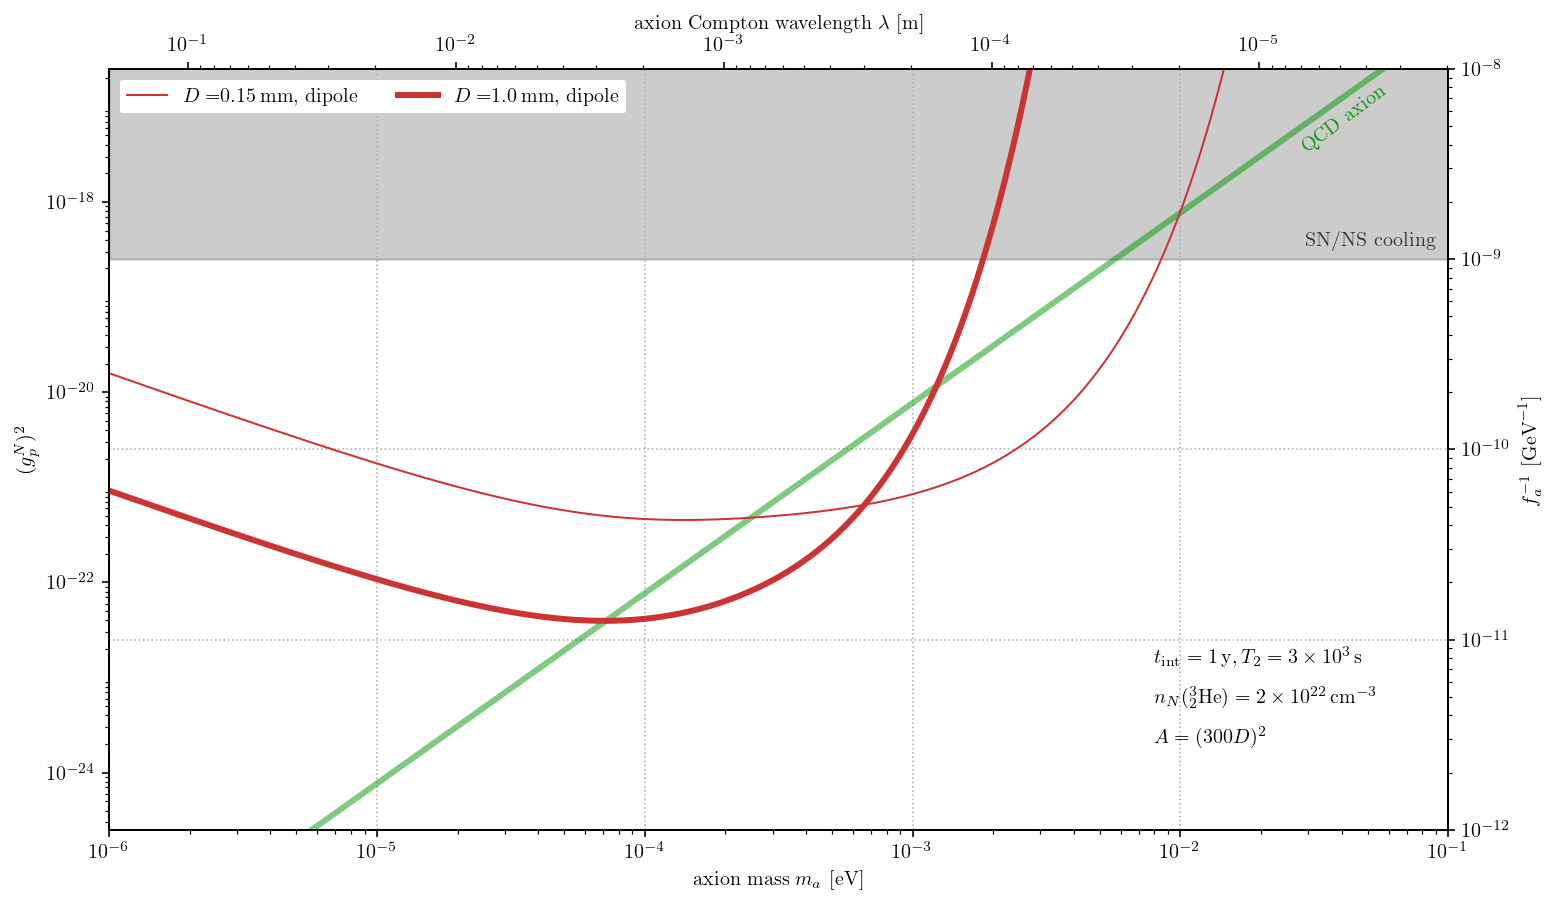

In [20]:
gpN2 = lambda fa_inv: (fa_inv * c_aNN*GeV)**2
ax2ticks = [10**(-i) for i in range(16, 25, 2)] 

fig, ax = plt.subplots(1,1,figsize=(12,7))
ax2 = ax.twinx()
ax2.set_yscale('log')
ax2.yaxis.tick_left()
ax2.set_yticks(ax2ticks)
ax2.yaxis.set_label_position('left')
ax2.set_ylim((gpN2(10**-12),gpN2(10**-8)))
ax2.set_ylabel('$(g_{p}^N)^2$')
ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlim(1e-6,1e-1); ax.set_ylim(1e-12,1e-8)
ax_top = ax.twiny();  ax_top.set_xlim(ax.get_xlim()); ax_top.set_xscale('log');
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_xlabel(r'axion mass $m_a~[\mathrm{eV}]$'); ax_top.set_xlabel('axion Compton wavelength $\lambda~[\mathrm{m}]$'); ax.set_ylabel('$f_a^{-1}~[\mathrm{GeV}^{-1}]$');
ticks_right_minor = np.outer(10**(np.arange(-19.0,-5)),np.arange(1.,10.,1.)).flatten()
ticks_right_minor = ticks_right_minor[(ax.get_ylim()[0] < ticks_right_minor) & (ticks_right_minor < ax.get_ylim()[1])]
ticks_right_major = 10**(np.arange(-12,-7.99))
ticks_top_minor = (np.outer(10**(np.arange(2.0,-6.01,-1)),np.arange(1.,10.,1.)).flatten() * meter)**-1 / eV; 
ticks_top_minor = ticks_top_minor[(ax_top.get_xlim()[0] < ticks_top_minor) & (ticks_top_minor < ax_top.get_xlim()[1])]
ticks_top_major = (10**(np.arange(-1.,-5.01,-1)) * meter)**-1 / eV
ax.set_yticks(ticks_right_minor,minor=True); ax.set_yticks(ticks_right_major,minor=False); 
ax.grid(ls='dotted',which='major',axis='both')
ax_top.set_xticks([],minor=True); ax_top.set_xticks(ticks_top_minor,minor=True); ax_top.set_xticklabels([],minor=True);
ax_top.set_xticks(ticks_top_major,minor=False); ax_top.set_xticklabels(['$10^{-1}$','$10^{-2}$','$10^{-3}$','$10^{-4}$','$10^{-5}$'],minor=False);
ax.plot(vec_ma/eV,1/fn_fa(vec_ma)*GeV,color=(0,0.6,0,0.5),lw=3);
ax.fill_between(vec_ma/eV,1e-9,1e-5,color=(0,0,0,0.2))
for i_D, D in enumerate(vec_D):
    vol = D**3 * vec_aspect[i_D]**2
    #plt.plot(vec_ma/eV,GeV*fn_fainv_sens_mon_mqm(vec_ma,D,h,rho_M,P_nuc,c_aNN,T_2,n_N,vol), lw=vec_lw[i_D], color=(1.0, 0.5, 0.0), label=vec_label[i_D]+', monopole (MQM)')
    #plt.plot(vec_ma/eV,GeV*fn_fainv_sens_mon(vec_ma,D,h,rho_S,P_nuc,c_aNN,T_2,n_N_det,vol),lw=vec_lw[i_D],color=(0.2,0.4,0.8),label=vec_label[i_D]+', monopole (Schiff)')
    plt.plot(vec_ma/eV,GeV*np.sqrt(fn_fa_2_inv_sens_dip(vec_ma,D,h,Eu.n_N,P_nuc,c_aNN,T_2,n_N_det,vol)),
             lw=vec_lw[i_D],color=(0.8,0.2,0.2),label=vec_label[i_D]+', dipole')
ax.text(6e-2,8.5e-9,'QCD axion',ha='right',va='top',color=(0,0.6,0,1),rotation=37);
ax.text(9e-2,1.1e-9,'SN/NS cooling',ha='right',va='bottom',color=(0.2,0.2,0.2),rotation=0);
ax.text(0.8e-2,2**(3.2)*1e-12,r'$t_\mathrm{int} = 1\,\mathrm{y}, T_2 = 3 \times 10^3\,\mathrm{s}$',va='top')
ax.text(0.8e-2,2**(2.5)*1e-12,r'$n_N({{}^{3}_2\mathrm{He}}) = 2 \times 10^{22} \, \mathrm{cm}^{-3}$',va='top')
ax.text(0.8e-2,2**(1.8)*1e-12,r'$A = (300 D)^2$',va='top')
#ax.text(0.8e-2,2**(1)*1e-12,r'${}^{235}_{92}\mathrm{U}$ source mass',va='top')

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1]
legend = ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize=10,loc='upper left', ncol=2, framealpha=1.0);

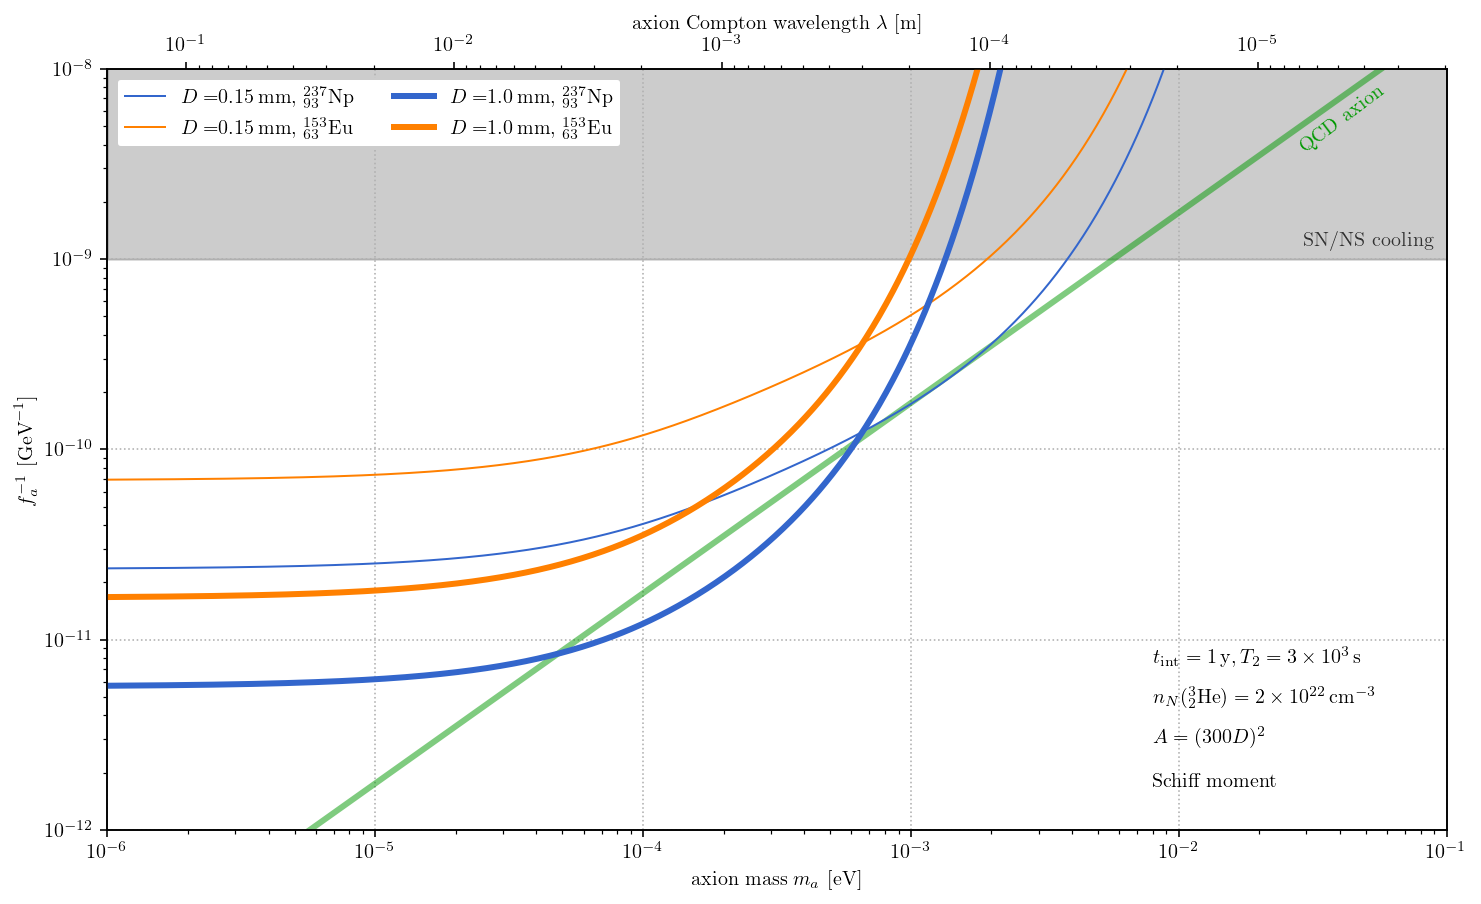

In [22]:
fig, ax = plt.subplots(1,1,figsize=(12,7))
ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlim(1e-6,1e-1); ax.set_ylim(1e-12,1e-8)
ax_top = ax.twiny();  ax_top.set_xlim(ax.get_xlim()); ax_top.set_xscale('log');
ax.yaxis.tick_left()
ax.yaxis.set_label_position("left")
ax.set_xlabel(r'axion mass $m_a~[\mathrm{eV}]$'); ax_top.set_xlabel('axion Compton wavelength $\lambda~[\mathrm{m}]$'); ax.set_ylabel('$f_a^{-1}~[\mathrm{GeV}^{-1}]$');
ticks_left_minor = np.outer(10**(np.arange(-19.0,-5)),np.arange(1.,10.,1.)).flatten()
ticks_left_minor = ticks_right_minor[(ax.get_ylim()[0] < ticks_right_minor) & (ticks_right_minor < ax.get_ylim()[1])]
ticks_left_major = 10**(np.arange(-12,-7.99))
ticks_top_minor = (np.outer(10**(np.arange(2.0,-6.01,-1)),np.arange(1.,10.,1.)).flatten() * meter)**-1 / eV; 
ticks_top_minor = ticks_top_minor[(ax_top.get_xlim()[0] < ticks_top_minor) & (ticks_top_minor < ax_top.get_xlim()[1])]
ticks_top_major = (10**(np.arange(-1.,-5.01,-1)) * meter)**-1 / eV
ax.set_yticks(ticks_left_minor,minor=True); ax.set_yticks(ticks_left_major,minor=False); 
ax.grid(ls='dotted',which='major',axis='both')
ax_top.set_xticks([],minor=True); ax_top.set_xticks(ticks_top_minor,minor=True); ax_top.set_xticklabels([],minor=True);
ax_top.set_xticks(ticks_top_major,minor=False); ax_top.set_xticklabels(['$10^{-1}$','$10^{-2}$','$10^{-3}$','$10^{-4}$','$10^{-5}$'],minor=False);
ax.plot(vec_ma/eV,1/fn_fa(vec_ma)*GeV,color=(0,0.6,0,0.5),lw=3);
ax.fill_between(vec_ma/eV,1e-9,1e-5,color=(0,0,0,0.2))
for i_D, D in enumerate(vec_D):
    vol = D**3 * vec_aspect[i_D]**2
    plt.plot(vec_ma/eV,GeV*np.sqrt(fn_fa_2_inv_sens_mon(vec_ma,D,h,Np.rho_s()[1],P_nuc,c_aNN,T_2,n_N_det,vol)),
             lw=vec_lw[i_D],color=(0.2,0.4,0.8),label=vec_label[i_D]+', ${}^{237}_{93}\mathrm{Np}$')
    plt.plot(vec_ma/eV,GeV*np.sqrt(fn_fa_2_inv_sens_mon(vec_ma,D,h,Eu.rho_s()[1],P_nuc,c_aNN,T_2,n_N_det,vol)),
             lw=vec_lw[i_D],color=(1.0, 0.5, 0.0),label=vec_label[i_D]+', ${}^{153}_{63}\mathrm{Eu}$')
ax.text(6e-2,8.5e-9,'QCD axion',ha='right',va='top',color=(0,0.6,0,1),rotation=37);
ax.text(9e-2,1.1e-9,'SN/NS cooling',ha='right',va='bottom',color=(0.2,0.2,0.2),rotation=0);
ax.text(0.8e-2,2**(3.2)*1e-12,r'$t_\mathrm{int} = 1\,\mathrm{y}, T_2 = 3 \times 10^3\,\mathrm{s}$',va='top')
ax.text(0.8e-2,2**(2.5)*1e-12,r'$n_N({{}^{3}_2\mathrm{He}}) = 2 \times 10^{22} \, \mathrm{cm}^{-3}$',va='top')
ax.text(0.8e-2,2**(1.8)*1e-12,r'$A = (300 D)^2$',va='top')
ax.text(0.8e-2,2**(1)*1e-12,r'Schiff moment',va='top')

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3]
legend = ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize=10,loc='upper left', ncol=2, framealpha=1.0);

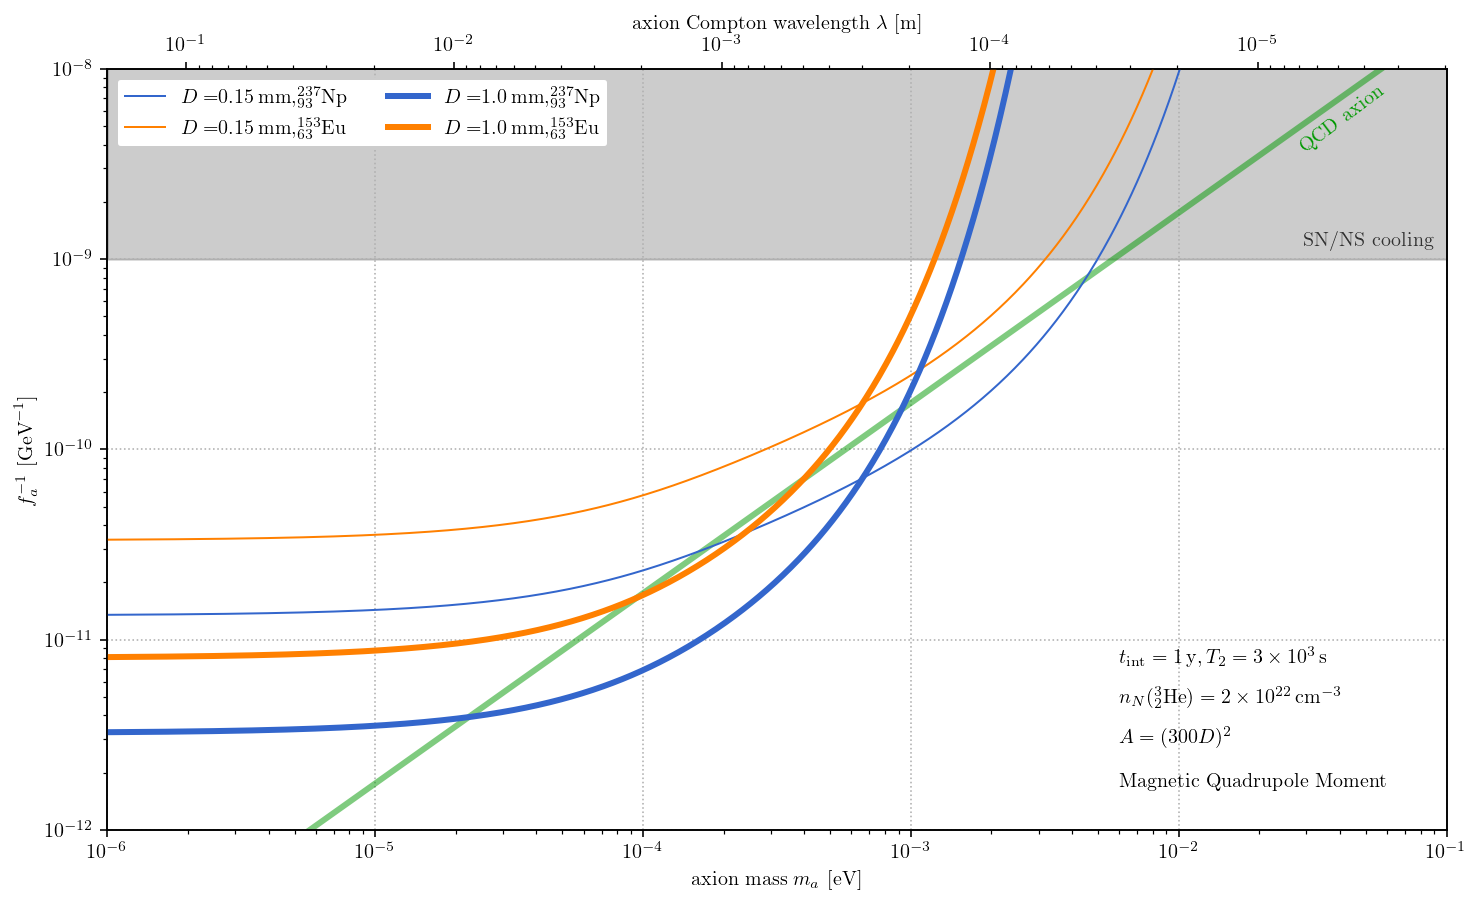

In [23]:
fig, ax = plt.subplots(1,1,figsize=(12,7))
ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlim(1e-6,1e-1); ax.set_ylim(1e-12,1e-8)
ax_top = ax.twiny();  ax_top.set_xlim(ax.get_xlim()); ax_top.set_xscale('log');
ax.yaxis.tick_left()
ax.yaxis.set_label_position("left")
ax.set_xlabel(r'axion mass $m_a~[\mathrm{eV}]$'); ax_top.set_xlabel('axion Compton wavelength $\lambda~[\mathrm{m}]$'); ax.set_ylabel('$f_a^{-1}~[\mathrm{GeV}^{-1}]$');
ticks_left_minor = np.outer(10**(np.arange(-19.0,-5)),np.arange(1.,10.,1.)).flatten()
ticks_left_minor = ticks_right_minor[(ax.get_ylim()[0] < ticks_right_minor) & (ticks_right_minor < ax.get_ylim()[1])]
ticks_left_major = 10**(np.arange(-12,-7.99))
ticks_top_minor = (np.outer(10**(np.arange(2.0,-6.01,-1)),np.arange(1.,10.,1.)).flatten() * meter)**-1 / eV; 
ticks_top_minor = ticks_top_minor[(ax_top.get_xlim()[0] < ticks_top_minor) & (ticks_top_minor < ax_top.get_xlim()[1])]
ticks_top_major = (10**(np.arange(-1.,-5.01,-1)) * meter)**-1 / eV
ax.set_yticks(ticks_left_minor,minor=True); ax.set_yticks(ticks_left_major,minor=False); 
ax.grid(ls='dotted',which='major',axis='both')
ax_top.set_xticks([],minor=True); ax_top.set_xticks(ticks_top_minor,minor=True); ax_top.set_xticklabels([],minor=True);
ax_top.set_xticks(ticks_top_major,minor=False); ax_top.set_xticklabels(['$10^{-1}$','$10^{-2}$','$10^{-3}$','$10^{-4}$','$10^{-5}$'],minor=False);
ax.plot(vec_ma/eV,1/fn_fa(vec_ma)*GeV,color=(0,0.6,0,0.5),lw=3);
ax.fill_between(vec_ma/eV,1e-9,1e-5,color=(0,0,0,0.2))
for i_D, D in enumerate(vec_D):
    vol = D**3 * vec_aspect[i_D]**2
    plt.plot(vec_ma/eV,GeV*np.sqrt(fn_fa_2_inv_sens_mon_mqm(vec_ma,D,h,Np.rho_m()[1],c_aNN,T_2,Np.n_N,vol)),
              lw=vec_lw[i_D], color=(0.2,0.4,0.8), label=vec_label[i_D]+',${}^{237}_{93}\mathrm{Np}$')
    plt.plot(vec_ma/eV,GeV*np.sqrt(fn_fa_2_inv_sens_mon_mqm(vec_ma,D,h,Eu.rho_m()[1],c_aNN,T_2,Eu.n_N,vol)),
              lw=vec_lw[i_D], color=(1.0, 0.5, 0.0), label=vec_label[i_D]+',${}^{153}_{63}\mathrm{Eu}$')
ax.text(6e-2,8.5e-9,'QCD axion',ha='right',va='top',color=(0,0.6,0,1),rotation=37);
ax.text(9e-2,1.1e-9,'SN/NS cooling',ha='right',va='bottom',color=(0.2,0.2,0.2),rotation=0);
ax.text(0.6e-2,2**(3.2)*1e-12,r'$t_\mathrm{int} = 1\,\mathrm{y}, T_2 = 3 \times 10^3\,\mathrm{s}$',va='top')
ax.text(0.6e-2,2**(2.5)*1e-12,r'$n_N({{}^{3}_2\mathrm{He}}) = 2 \times 10^{22} \, \mathrm{cm}^{-3}$',va='top')
ax.text(0.6e-2,2**(1.8)*1e-12,r'$A = (300 D)^2$',va='top')
ax.text(0.6e-2,2**(1)*1e-12,r'Magnetic Quadrupole Moment',va='top')

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3]
legend = ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize=10,loc='upper left', ncol=2, framealpha=1.0);